# Program Disertatie

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import time

### Uniform Distribution

In [2]:
def generate_uniform_data(mean, std_dev, shape):
    min_val = mean - std_dev * 3
    max_val = mean + std_dev * 3

    data = np.random.uniform(min_val, max_val, shape)
    return data

## Panel Data Generation


In [3]:
def generare_date_panel(N, T, sigma_err, sigma_alpha, beta1, beta2 ):
    
    # Generate the variables x1 and x2
    X1 = generate_uniform_data(3, 2, N*T)
    X1 = np.array(X1).reshape(N*T,)
    X2 = np.random.normal(36, 25, N*T)
    X2 = np.array(X2).reshape(N*T,)

    beta0 = np.random.RandomState(seed=42).rand(N,)*10

    # Generate individual random effects
    alpha = np.kron(np.eye(N),np.ones((T, 1)))

    # Generate the errors
    epsilon = generate_uniform_data(0, sigma_err, N*T)
    epsilon = np.array(epsilon).reshape(N*T, 1)

    arg1 = np.array(beta0.repeat(T)).reshape(N*T,1)
    arg2 = np.array(beta1*X1).reshape(N*T, 1)
    arg3 = np.array(beta2*X2).reshape(N*T, 1)
    arg4 = np.array(np.random.normal(0,sigma_alpha, N).reshape(N,1))
  

    # Generating Y with random effects
    Y = arg1+ arg2+ arg3 + np.dot(alpha,arg4) + epsilon
    Y = np.array(Y).reshape(N*T,)
    
    # Create the panel using pandas DataFrame
    data = pd.DataFrame({'id': np.repeat(np.arange(N), T),
                         'time': np.tile(np.arange(T), N),
                         'Y': Y,
                         'X1': X1,
                         'X2': X2                 
                        })

    return data



### PooledOLS

In [4]:
def PooledOLS():
    global beta1_array, beta2_array
    Y = df_panel.iloc[:,2]
    X = df_panel.iloc[:,3:]

    pooled_olsr_model = sm.OLS(Y, sm.add_constant(X))    
    pooled_olsr_model_results = pooled_olsr_model.fit()
    
    # Extract the coefficients beta1 and beta2
    beta1 = pooled_olsr_model_results.params[1]  # Beta 1 coefficient
    beta2 = pooled_olsr_model_results.params[2]  # Beta 2 coefficient
    
    # Add the coefficients to arrays
    beta1_array = np.append(beta1_array, beta1)
    beta2_array = np.append(beta2_array, beta2)

### Within

In [5]:
def Within():
    global beta1_arrayb, beta2_arrayb

    #Define x si y
    Y = df_panel.iloc[:,2]
    X = df_panel.iloc[:,3:]

    y_var_name = 'Y'
    X_var_names = ['X1','X2']

    unit_col_name=df_panel.columns[0]

    #Create the dummy variables, one for each country
    df_dummies = pd.get_dummies(df_panel[unit_col_name], prefix = 'id')

    # Join the dummies Dataframe to the panel data set:
    df_panel_with_dummies = df_panel.join(df_dummies)
    
    # Construct the regression equation
    lsdv_expr = f"{y_var_name} ~ {' + '.join(X_var_names)} + {' + '.join(df_dummies.columns[:-1])}"
    
    # Build and train an LSDV model on the panel data containing dummies:
    lsdv_model = smf.ols(formula=lsdv_expr, data=df_panel_with_dummies)
    lsdv_model_results = lsdv_model.fit()

    # Extract the coefficients beta1 and beta2
    beta1 = lsdv_model_results.params[1]  # Beta 1 coefficient
    beta2 = lsdv_model_results.params[2]  # Beta 2 coefficient

    
    # Add the coefficients to arrays
    beta1_arrayb = np.append(beta1_arrayb, beta1)
    beta2_arrayb = np.append(beta2_arrayb, beta2)

##### Format the obtained data into tables

In [6]:
def tableData(data):
    global N_values,T_values
    
    # Split the data into separate arrays based on N
    arrays = np.split(data, len(N_values))

    # Combine the arrays vertically
    combined_array = np.vstack(arrays)

    # Create column names based on T
    column_names = ['T=' + str(t) for t in T_values]

    # Transform the combined array into a pandas DataFrame
    df = pd.DataFrame(combined_array, columns=column_names)

    # Add a new first column with the variation of N
    df.insert(0, 'N\T', ['N=' + str(n) for n in N_values])

    return df

#### Generate line plots with the data from the tables

In [7]:
def plot_line_plots(data):
    # Extract data from the table
    plot_data = data.iloc[:, 1:].values
    row_names = data.iloc[:, 0].values

    # Set up the figure and axes
    fig, ax = plt.subplots()

    # Iterate over each row in the data
    for i in range(len(plot_data)):
        x = np.arange(len(plot_data[i]))  # x-axis values
        y = plot_data[i]  # y-axis values

        # Plot
        ax.plot(x, y, label=row_names[i])

    # Set the x-axis labels
    x_labels = data.columns[1:]
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels)

    # Move the legend outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Set the axis labels and title
    ax.set_xlabel('Perioade de timp')
    ax.set_ylabel('')
    ax.set_title('')

    # Adjust the layout
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    # Display the plot
    plt.show()

#### Generate combined line plots

In [8]:
def plot_line_comb(data1, data2):
    # Extract data from tables
    plot_data1 = data1.iloc[:, 1:].values
    plot_data2 = data2.iloc[:, 1:].values
    row_names = data1.iloc[:, 0].values
    column_names = data1.columns[1:]

    num_rows = plot_data1.shape[0]

    # Determine the number of subplots
    num_cols = 2
    num_subplots = num_rows // num_cols + num_rows % num_cols

    # Create subplots
    fig, axs = plt.subplots(num_subplots, num_cols, figsize=(10, 5))

    # Flatten the axs array if num_subplots is 1
    if num_subplots == 1:
        axs = [axs]

    # Iterate through each row and create line plots
    for i, row in enumerate(range(num_rows)):
        row_data1 = plot_data1[row, :]
        row_data2 = plot_data2[row, :]
        ax = axs[i // num_cols][i % num_cols]
        ax.plot(column_names, row_data1, label='PooledOLS')
        ax.plot(column_names, row_data2, label='Within')
        ax.set_title(row_names[row])
        ax.legend()

    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()

# Main Program

Done N =  10
Elapsed time: 25.571095943450928 seconds
Done N =  50
Elapsed time: 127.41162991523743 seconds
Done N =  90
Elapsed time: 409.2765386104584 seconds
Done N =  130
Elapsed time: 945.6832818984985 seconds
Done N =  170
Elapsed time: 1830.0005095005035 seconds
Done N =  210
Elapsed time: 3183.8957369327545 seconds
PooledOLS Results:
Mean Beta1: 

     N\T      T=10      T=50      T=90     T=130     T=170     T=210
0   N=10  6.993765  7.005372  6.998805  7.003694  6.999439  6.997903
1   N=50  7.000505  6.996944  6.996611  7.001260  7.000678  7.000280
2   N=90  6.999033  7.001562  7.000055  7.000898  6.999572  6.999549
3  N=130  6.997821  7.000152  6.997981  6.999674  7.000249  7.000049
4  N=170  6.997803  7.001018  7.001182  7.000294  6.998938  7.000232
5  N=210  7.001238  6.999494  7.000932  6.999788  7.000075  6.999703
Mean Beta2: 
      N\T      T=10      T=50      T=90     T=130     T=170     T=210
0   N=10  3.999669  3.999707  4.000063  4.000021  3.999725  4.000470
1   N=5

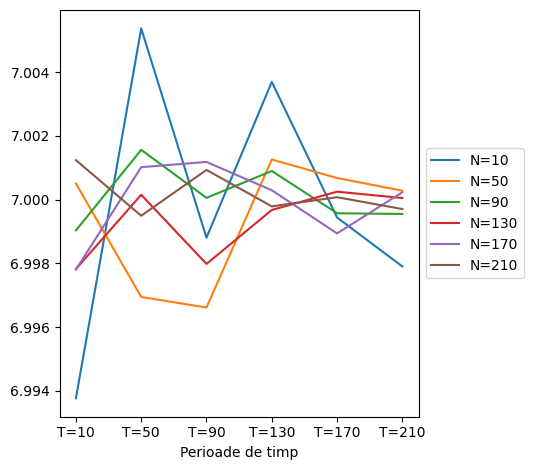

Mean of estimated beta2


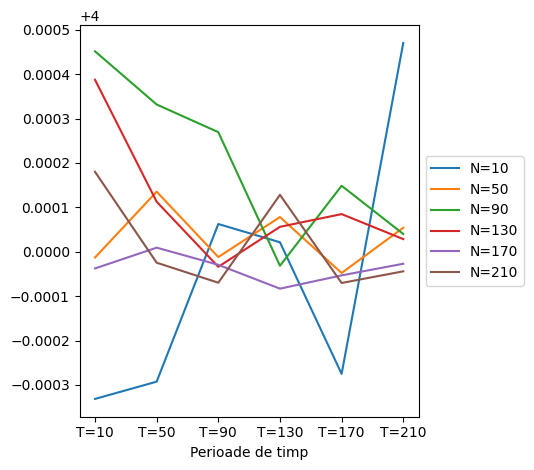

Standard deviation of beta1


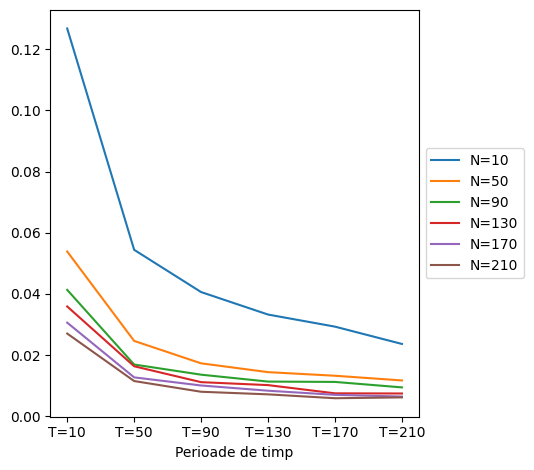

Standard deviation of beta2


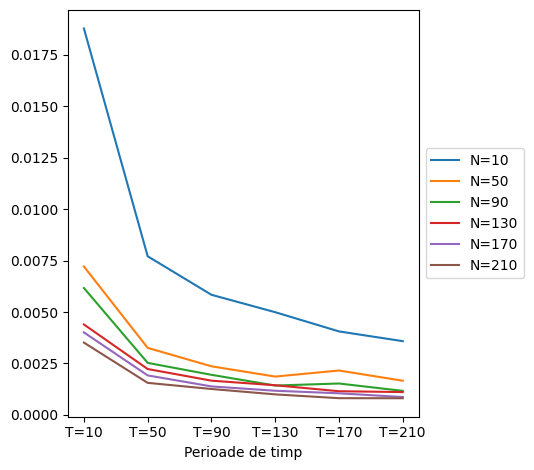

Within plots:
Mean of estimated beta1


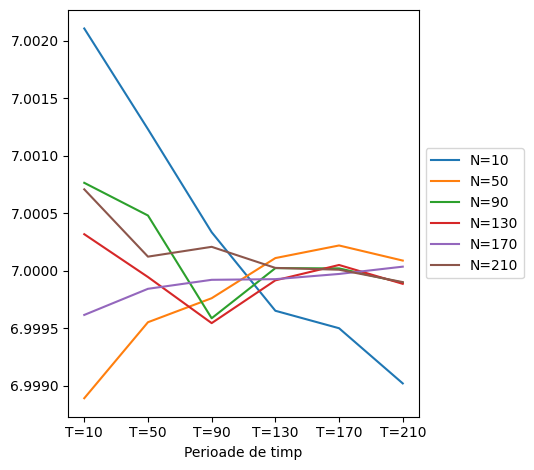

Mean of estimated beta2


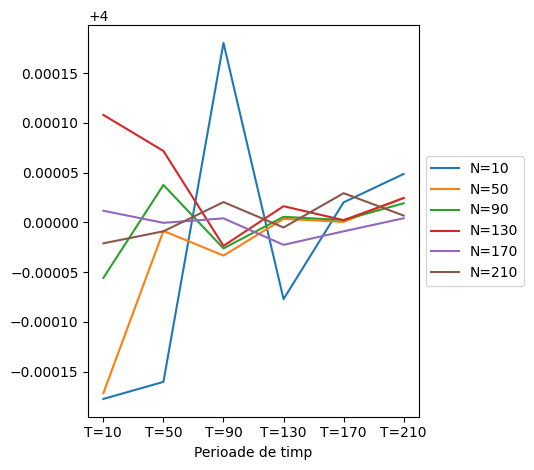

Standard deviation of beta1


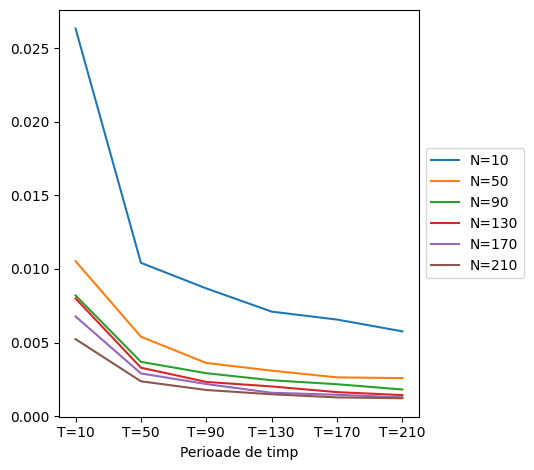

Standard deviation of beta2


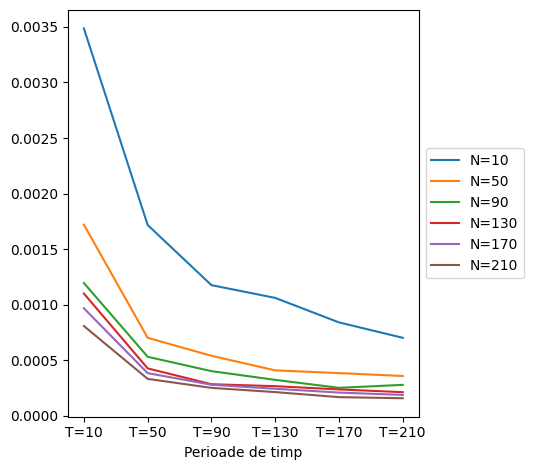

Combined plots:
Mean of estimated beta1


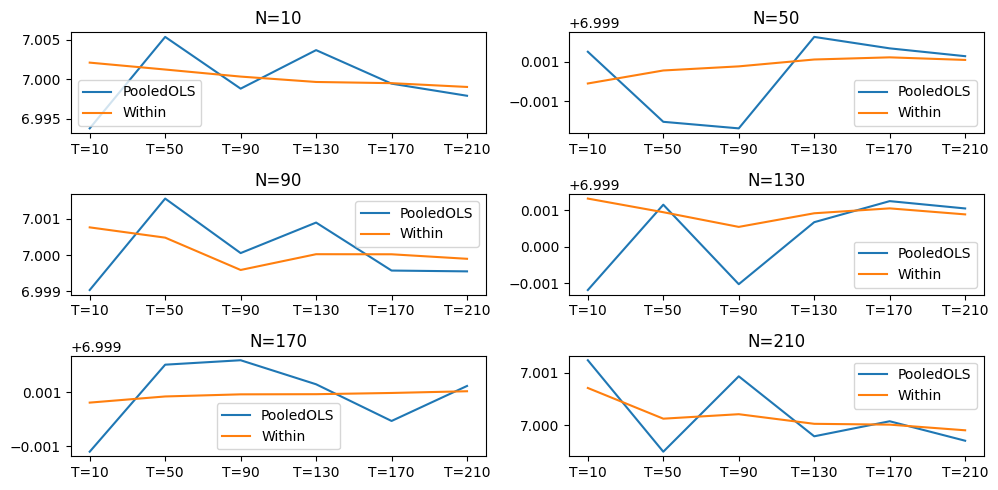

Mean of estimated beta2


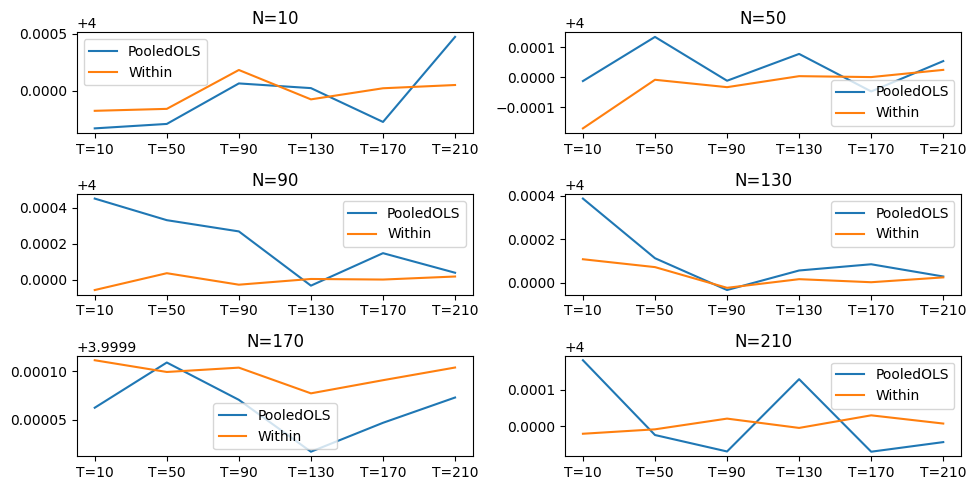

Standard deviation of beta1


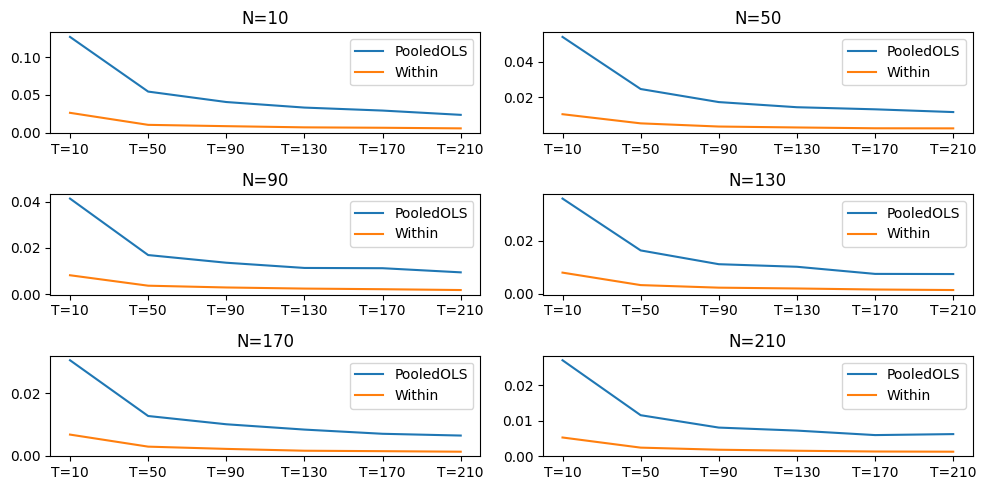

Standard deviation of beta2


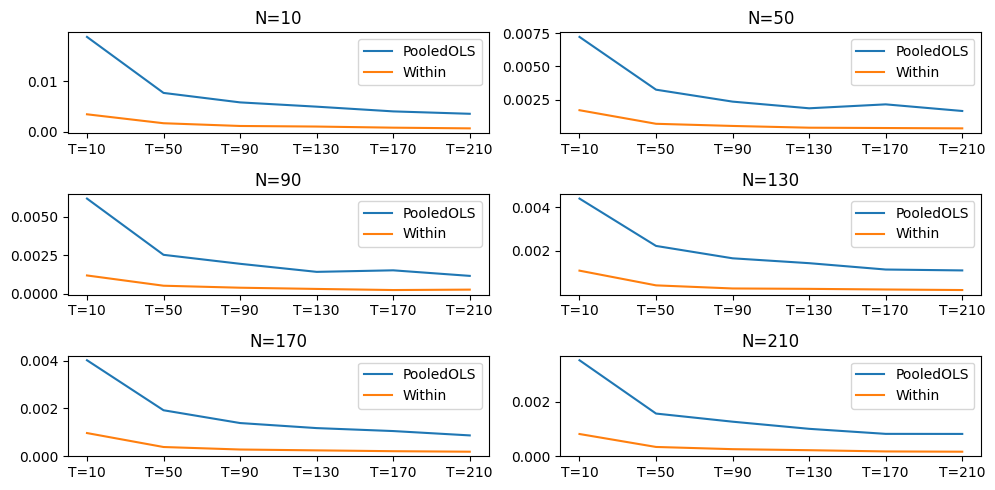

In [9]:
## Main ##

# Define parameters
N_values = [10, 50, 90, 130, 170, 210]  # number of individuals
T_values = [10, 50, 90, 130, 170, 210]  # time periods for each panel
sigma_err = 0.5
sigma_alpha = 3
beta1 = 7
beta2 = 4


# Vectors to store all the Monte Carlo simulation results: PooledOLS
mean_beta1_general = np.array([])
mean_beta2_general = np.array([])
std_deviation_beta1_general = np.array([])
std_deviation_beta2_general = np.array([])

# Vectors to store all the Monte Carlo simulation results: Within
mean_beta1_generalb = np.array([])
mean_beta2_generalb = np.array([])
std_deviation_beta1_generalb = np.array([])
std_deviation_beta2_generalb = np.array([])

# Start the timer
start_time = time.time()


#Loop over individual values
for N in N_values:
    # Loop over time period values
    for T in T_values:
        
        # Vectors to store Beta1, Beta2 values: PooledOLS
        beta1_array = np.array([])
        beta2_array = np.array([])
        
        # Vectors to store Beta1, Beta2 values: Within
        beta1_arrayb = np.array([])
        beta2_arrayb = np.array([])

        # Create panel for each time period value
        for i in range(200):
        
            # Generate panel data for each individual
            df_panel = generare_date_panel(N, T, sigma_err, sigma_alpha , beta1, beta2)

            #Perform PooledOLS estimation and extracting beta1 and beta2
            PooledOLS()
            #Perform Within estimation and extracting beta1 and beta2
            Within()

          
        # Calculate mean and standard deviation: PooledOLS
        mean_value_beta1 = np.mean(beta1_array)
        mean_value_beta2 = np.mean(beta2_array)
        std_deviation_beta1 = np.std(beta1_array)
        std_deviation_beta2 = np.std(beta2_array)

        # Append results to the general vectors: PooledOLS
        mean_beta1_general = np.append(mean_beta1_general,mean_value_beta1)
        mean_beta2_general = np.append(mean_beta2_general,mean_value_beta2)
        std_deviation_beta1_general = np.append(std_deviation_beta1_general,std_deviation_beta1)
        std_deviation_beta2_general = np.append(std_deviation_beta2_general,std_deviation_beta2)

        # Calculate mean and standard deviation: Within
        mean_value_beta1b = np.mean(beta1_arrayb)
        mean_value_beta2b = np.mean(beta2_arrayb)
        std_deviation_beta1b = np.std(beta1_arrayb)
        std_deviation_beta2b = np.std(beta2_arrayb)
        
        # Append results to the general vectors: Within
        mean_beta1_generalb = np.append(mean_beta1_generalb,mean_value_beta1b)
        mean_beta2_generalb = np.append(mean_beta2_generalb,mean_value_beta2b)
        std_deviation_beta1_generalb = np.append(std_deviation_beta1_generalb,std_deviation_beta1b)
        std_deviation_beta2_generalb = np.append(std_deviation_beta2_generalb,std_deviation_beta2b)

    print("Done N = ", N)
    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    # Print the running time
    print(f"Elapsed time: {elapsed_time} seconds")        

#Results PooledOLS
print("PooledOLS Results:")
mean_beta1 = tableData(mean_beta1_general)
print("Mean Beta1: \n")
print( mean_beta1)
mean_beta2 = tableData(mean_beta2_general)
print("Mean Beta2: \n", mean_beta2)
std_beta1 = tableData(std_deviation_beta1_general)
print("Standard Deviation Beta1: \n", std_beta1)
std_beta2 = tableData(std_deviation_beta2_general)
print("Standard Deviation Beta2: \n", std_beta2)

#Results Within
print("Within Results:")
mean_beta1b = tableData(mean_beta1_generalb)
print("Mean Beta1: \n")
print( mean_beta1b)
mean_beta2b = tableData(mean_beta2_generalb)
print("Mean Beta2: \n", mean_beta2b)
std_beta1b = tableData(std_deviation_beta1_generalb)
print("Standard Deviation Beta1: \n", std_beta1b)
std_beta2b = tableData(std_deviation_beta2_generalb)
print("Standard Deviation Beta2: \n", std_beta2b)

#Ploturi PooledOLS
print("PooledOLS plots:")
print("Mean of estimated beta1")
plot_line_plots(mean_beta1)
print("Mean of estimated beta2")
plot_line_plots(mean_beta2)
print("Standard deviation of beta1")
plot_line_plots(std_beta1)
print("Standard deviation of beta2")
plot_line_plots(std_beta2)

#Ploturi Within
print("Within plots:")
print("Mean of estimated beta1")
plot_line_plots(mean_beta1b)
print("Mean of estimated beta2")
plot_line_plots(mean_beta2b)
print("Standard deviation of beta1")
plot_line_plots(std_beta1b)
print("Standard deviation of beta2")
plot_line_plots(std_beta2b)

#Ploturi combinate
print("Combined plots:")
print("Mean of estimated beta1")
plot_line_comb(mean_beta1,mean_beta1b)
print("Mean of estimated beta2")
plot_line_comb(mean_beta2,mean_beta2b)
print("Standard deviation of beta1")
plot_line_comb(std_beta1,std_beta1b)
print("Standard deviation of beta2")
plot_line_comb(std_beta2,std_beta2b)